In [1]:
# %% [markdown]
# # Fast Food Consumption Health Impact Analysis

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
url = "https://raw.githubusercontent.com/dangoled/MLZoomcamp2025_Capstone2/refs/heads/main/data/fast_food_consumption_health_impact_dataset.csv"
df = pd.read_csv(url)
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())

Dataset shape: (800, 11)

First few rows:
   Age  Gender  Fast_Food_Meals_Per_Week  Average_Daily_Calories   BMI  \
0   56    Male                         1                    3153  28.4   
1   46    Male                        12                    1748  22.8   
2   32  Female                         8                    3020  21.5   
3   25  Female                         6                    2621  26.8   
4   38  Female                        14                    2260  18.1   

   Physical_Activity_Hours_Per_Week  Sleep_Hours_Per_Day  Energy_Level_Score  \
0                               4.5                  7.8                   9   
1                               9.6                  6.7                   2   
2                               4.0                  7.4                   2   
3                               8.4                  6.1                   6   
4                               1.9                  7.7                   7   

  Digestive_Issues  Doctor_Visit

In [3]:
# Basic information
print("Dataset Info:")
print(df.info())
print("\nMissing values:")
print(df.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Age                               800 non-null    int64  
 1   Gender                            800 non-null    object 
 2   Fast_Food_Meals_Per_Week          800 non-null    int64  
 3   Average_Daily_Calories            800 non-null    int64  
 4   BMI                               800 non-null    float64
 5   Physical_Activity_Hours_Per_Week  800 non-null    float64
 6   Sleep_Hours_Per_Day               800 non-null    float64
 7   Energy_Level_Score                800 non-null    int64  
 8   Digestive_Issues                  800 non-null    object 
 9   Doctor_Visits_Per_Year            800 non-null    int64  
 10  Overall_Health_Score              800 non-null    int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 68.9+ KB

In [4]:
# Descriptive statistics
print("Descriptive Statistics:")
print(df.describe())

Descriptive Statistics:
              Age  Fast_Food_Meals_Per_Week  Average_Daily_Calories  \
count  800.000000                800.000000              800.000000   
mean    38.802500                  6.818750             2554.728750   
std     12.055919                  4.329183              551.078974   
min     18.000000                  0.000000             1600.000000   
25%     29.000000                  3.000000             2084.750000   
50%     40.000000                  7.000000             2540.500000   
75%     49.000000                 11.000000             3049.000000   
max     59.000000                 14.000000             3499.000000   

             BMI  Physical_Activity_Hours_Per_Week  Sleep_Hours_Per_Day  \
count  800.00000                        800.000000           800.000000   
mean    26.43900                          4.938000             6.472875   
std      4.94144                          2.860272             1.429232   
min     18.00000                    

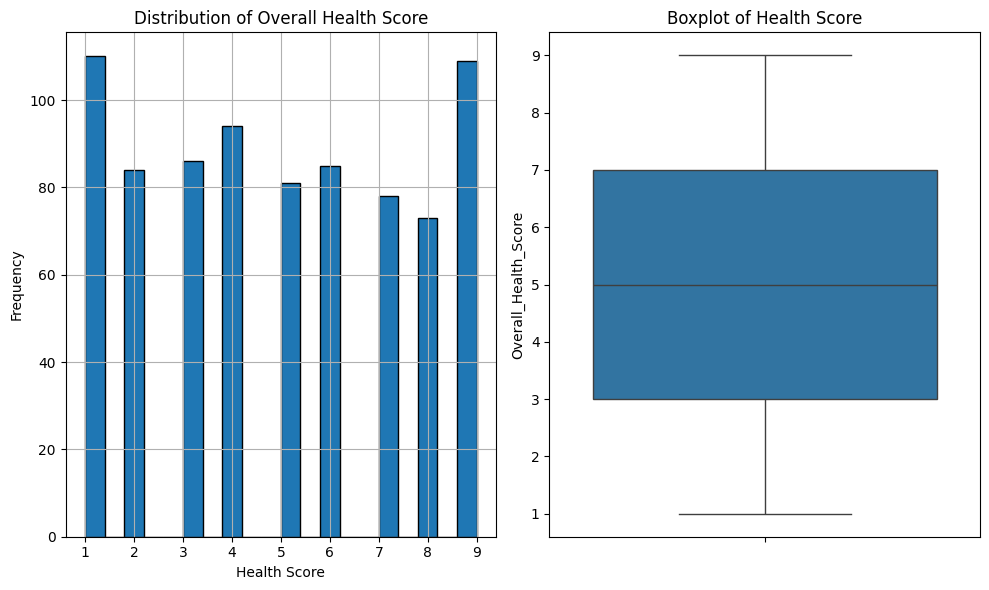

In [5]:
# Check target distribution
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
df['Overall_Health_Score'].hist(bins=20, edgecolor='black')
plt.title('Distribution of Overall Health Score')
plt.xlabel('Health Score')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['Overall_Health_Score'])
plt.title('Boxplot of Health Score')

plt.tight_layout()
plt.show()

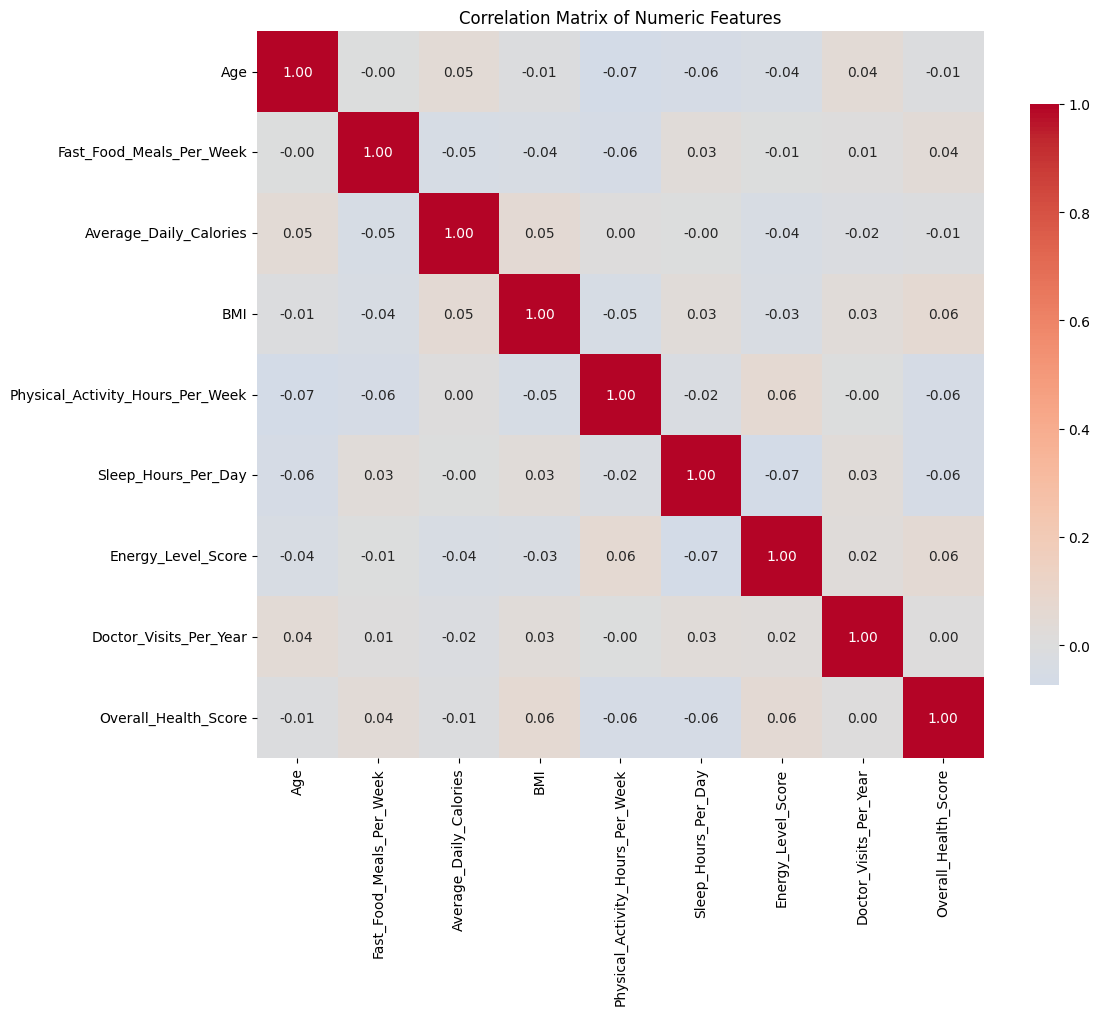

In [6]:
# Correlation matrix
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', square=True, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.show()

In [7]:
# Correlation with target
target_corr = correlation_matrix['Overall_Health_Score'].sort_values(ascending=False)
print("Correlation with Overall Health Score:")
print(target_corr)

Correlation with Overall Health Score:
Overall_Health_Score                1.000000
BMI                                 0.061348
Energy_Level_Score                  0.055733
Fast_Food_Meals_Per_Week            0.037271
Doctor_Visits_Per_Year              0.001376
Age                                -0.007558
Average_Daily_Calories             -0.011145
Physical_Activity_Hours_Per_Week   -0.059117
Sleep_Hours_Per_Day                -0.059745
Name: Overall_Health_Score, dtype: float64


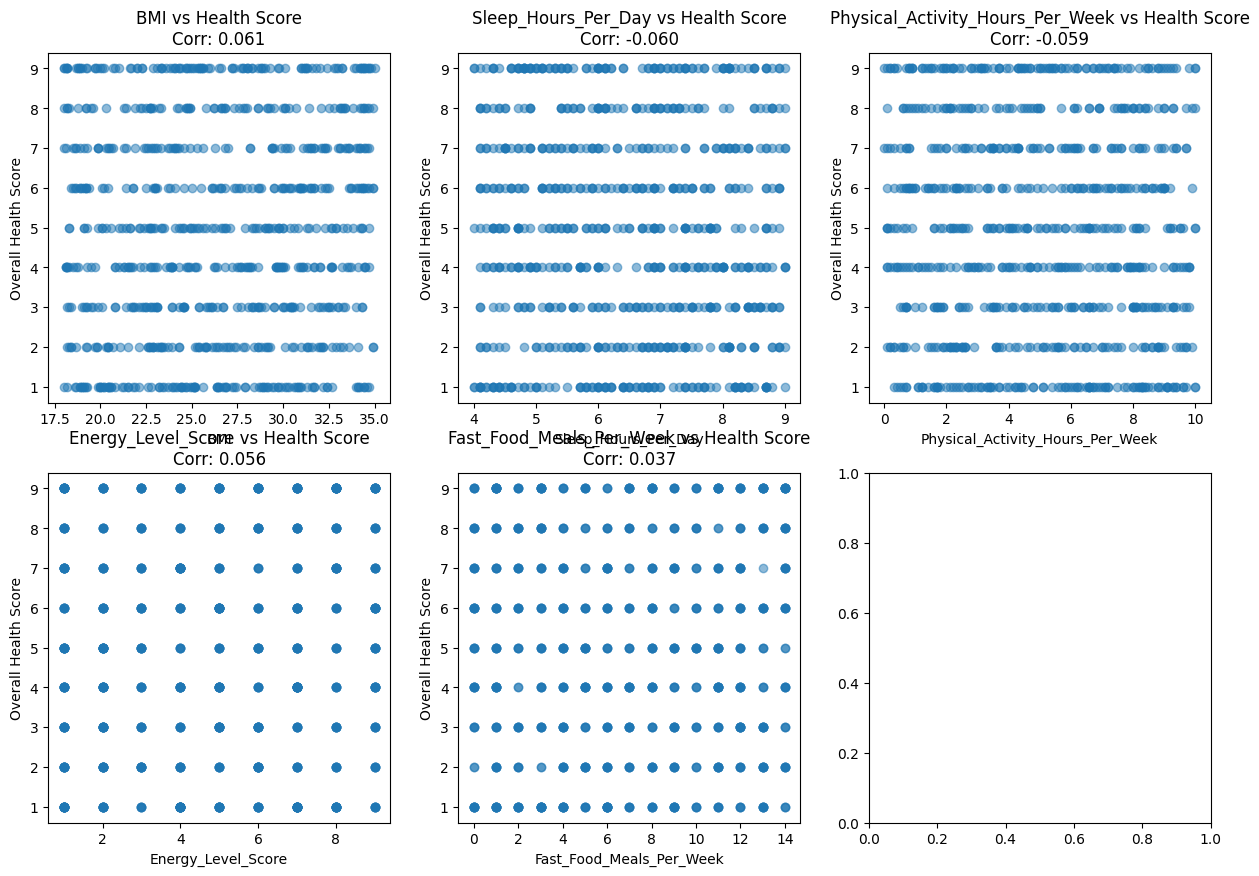

In [8]:
# Visualize top correlations
top_features = target_corr.abs().sort_values(ascending=False).index[1:6]  # Exclude self-correlation

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(top_features):
    axes[i].scatter(df[feature], df['Overall_Health_Score'], alpha=0.5)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Overall Health Score')
    axes[i].set_title(f'{feature} vs Health Score\nCorr: {target_corr[feature]:.3f}')

Categorical columns: ['Gender', 'Digestive_Issues']

Gender distribution:
Gender
Male      385
Female    381
Other      34
Name: count, dtype: int64


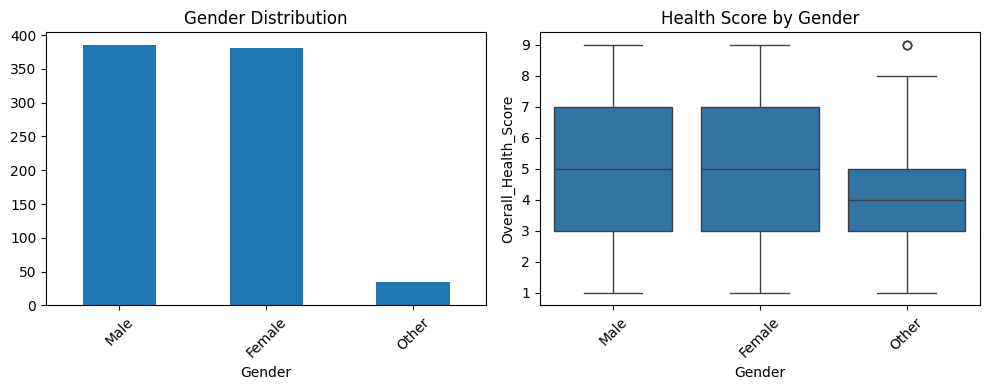


Digestive_Issues distribution:
Digestive_Issues
No     497
Yes    303
Name: count, dtype: int64


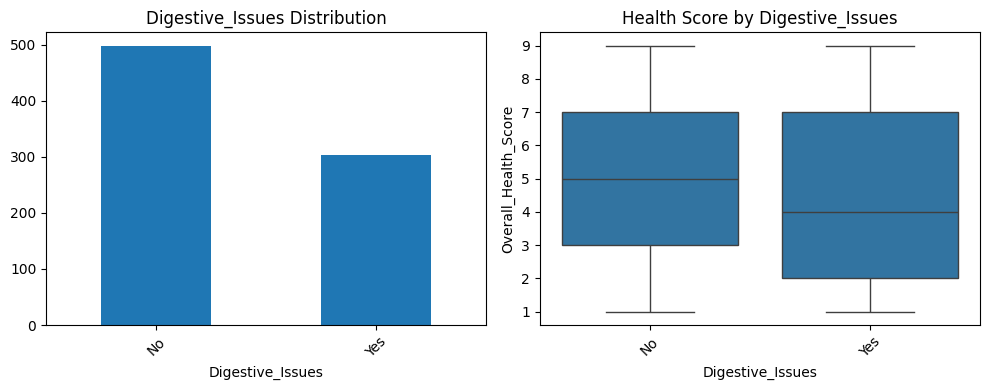

In [9]:
# Analyze categorical features
categorical_cols = df.select_dtypes(include=['object']).columns
print("Categorical columns:", categorical_cols.tolist())

for col in categorical_cols:
    print(f"\n{col} distribution:")
    print(df[col].value_counts())
    
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    df[col].value_counts().plot(kind='bar')
    plt.title(f'{col} Distribution')
    plt.xticks(rotation=45)
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x=col, y='Overall_Health_Score', data=df)
    plt.title(f'Health Score by {col}')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

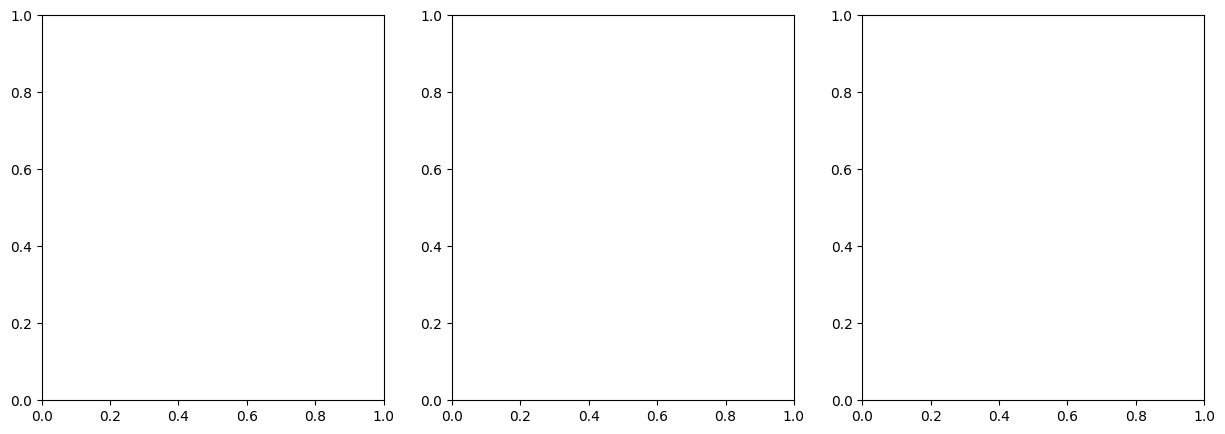

In [10]:
# Analyze Fast_Food_Meals_Per_Week
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

In [11]:
# Distribution
axes[0].hist(df['Fast_Food_Meals_Per_Week'], bins=20, edgecolor='black')
axes[0].set_xlabel('Fast Food Meals Per Week')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Fast Food Consumption')

Text(0.5, 1.0, 'Distribution of Fast Food Consumption')

In [12]:
# Scatter plot
axes[1].scatter(df['Fast_Food_Meals_Per_Week'], df['Overall_Health_Score'], alpha=0.5)
axes[1].set_xlabel('Fast Food Meals Per Week')
axes[1].set_ylabel('Overall Health Score')
axes[1].set_title('Fast Food vs Health Score')

Text(0.5, 1.0, 'Fast Food vs Health Score')

In [13]:
# Box plot
df['Fast_Food_Group'] = pd.cut(df['Fast_Food_Meals_Per_Week'], 
                               bins=[0, 3, 7, 14], 
                               labels=['Low (0-3)', 'Medium (4-7)', 'High (8-14)'])
sns.boxplot(x='Fast_Food_Group', y='Overall_Health_Score', data=df, ax=axes[2])
axes[2].set_title('Health Score by Fast Food Consumption Group')
axes[2].set_xlabel('Fast Food Consumption Group')
axes[2].set_ylabel('Overall Health Score')

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

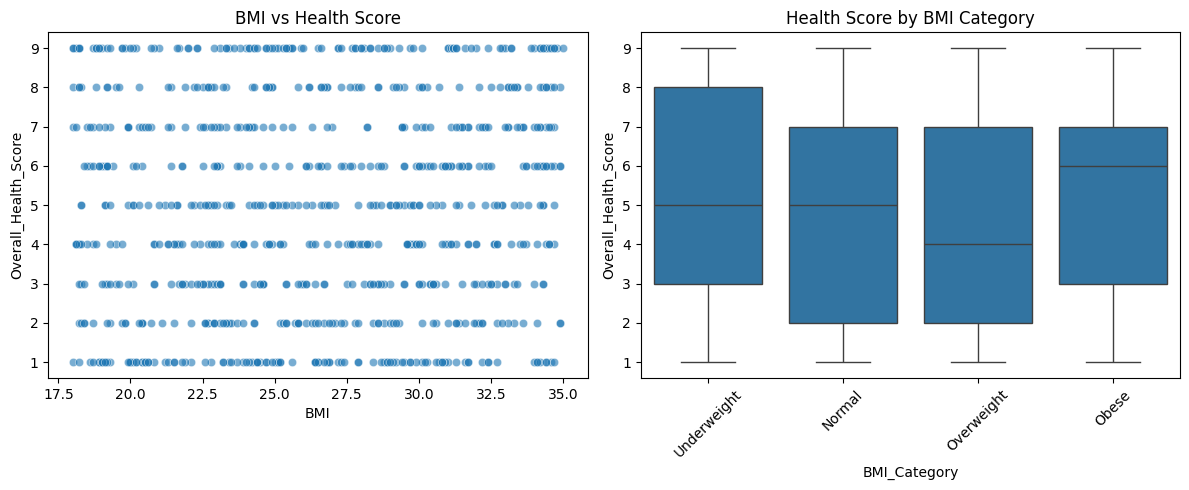

In [14]:
# BMI analysis
df['BMI_Category'] = pd.cut(df['BMI'], 
                            bins=[0, 18.5, 25, 30, 100], 
                            labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x='BMI', y='Overall_Health_Score', data=df, alpha=0.6)
plt.title('BMI vs Health Score')

plt.subplot(1, 2, 2)
sns.boxplot(x='BMI_Category', y='Overall_Health_Score', data=df)
plt.title('Health Score by BMI Category')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

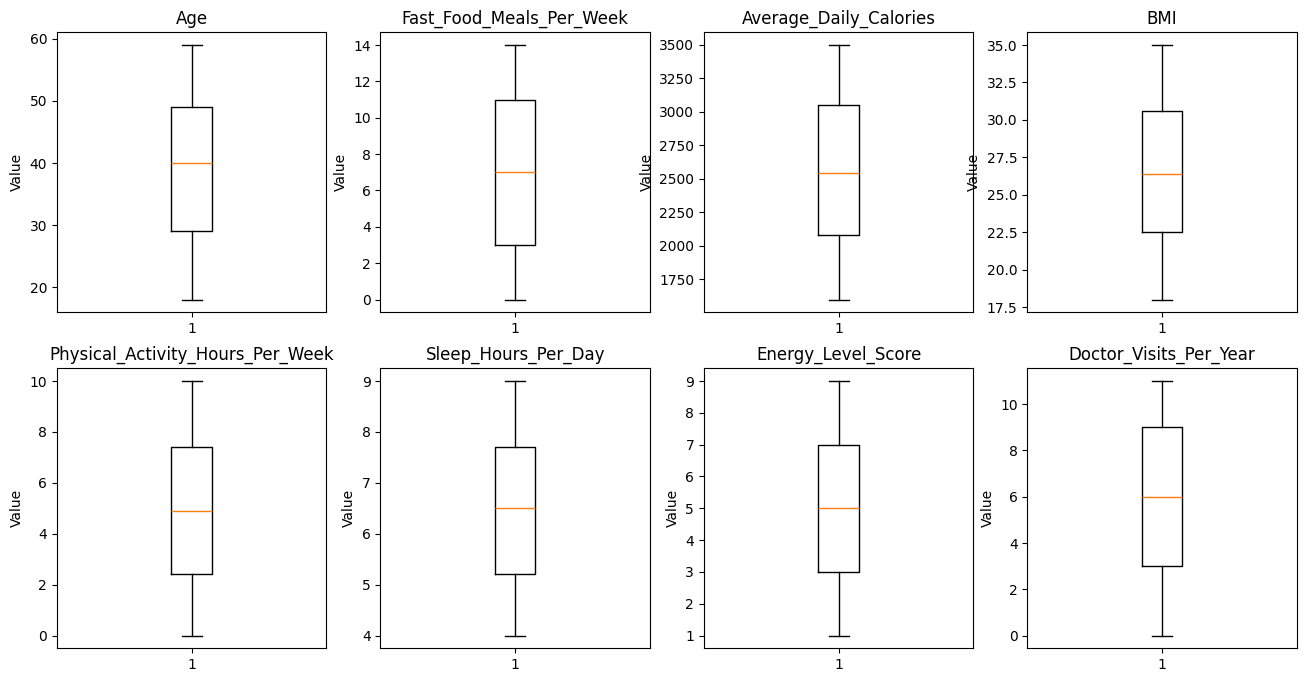

In [15]:
# Check for outliers
numeric_features = ['Age', 'Fast_Food_Meals_Per_Week', 'Average_Daily_Calories', 
                    'BMI', 'Physical_Activity_Hours_Per_Week', 'Sleep_Hours_Per_Day', 
                    'Energy_Level_Score', 'Doctor_Visits_Per_Year']

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, feature in enumerate(numeric_features):
    axes[i].boxplot(df[feature].dropna())
    axes[i].set_title(f'{feature}')
    axes[i].set_ylabel('Value')

In [16]:
# Remove empty subplots
for j in range(len(numeric_features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [17]:
# Prepare data for modeling
X = df.drop('Overall_Health_Score', axis=1)
y = df['Overall_Health_Score']

In [18]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (640, 12)
Test set: (160, 12)


In [19]:
# Define preprocessing
numeric_features = ['Age', 'Fast_Food_Meals_Per_Week', 'Average_Daily_Calories',
                    'BMI', 'Physical_Activity_Hours_Per_Week', 'Sleep_Hours_Per_Day',
                    'Energy_Level_Score', 'Doctor_Visits_Per_Year']
categorical_features = ['Gender']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ]
)

In [20]:
# Train multiple models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'model': pipeline,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'predictions': y_pred
    }
    
    print(f"\n{name}:")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R²: {r2:.4f}")


Linear Regression:
  MSE: 6.8775
  RMSE: 2.6225
  MAE: 2.2327
  R²: -0.0502

Random Forest:
  MSE: 7.3519
  RMSE: 2.7114
  MAE: 2.3024
  R²: -0.1227

Gradient Boosting:
  MSE: 7.4327
  RMSE: 2.7263
  MAE: 2.2945
  R²: -0.1350


In [21]:
# Compare models
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'MSE': [results[m]['mse'] for m in results],
    'RMSE': [results[m]['rmse'] for m in results],
    'MAE': [results[m]['mae'] for m in results],
    'R²': [results[m]['r2'] for m in results]
}).sort_values('RMSE')

print("Model Comparison:")
print(comparison_df)

Model Comparison:
               Model       MSE      RMSE       MAE        R²
0  Linear Regression  6.877491  2.622497  2.232675 -0.050224
1      Random Forest  7.351906  2.711440  2.302375 -0.122669
2  Gradient Boosting  7.432709  2.726299  2.294539 -0.135008


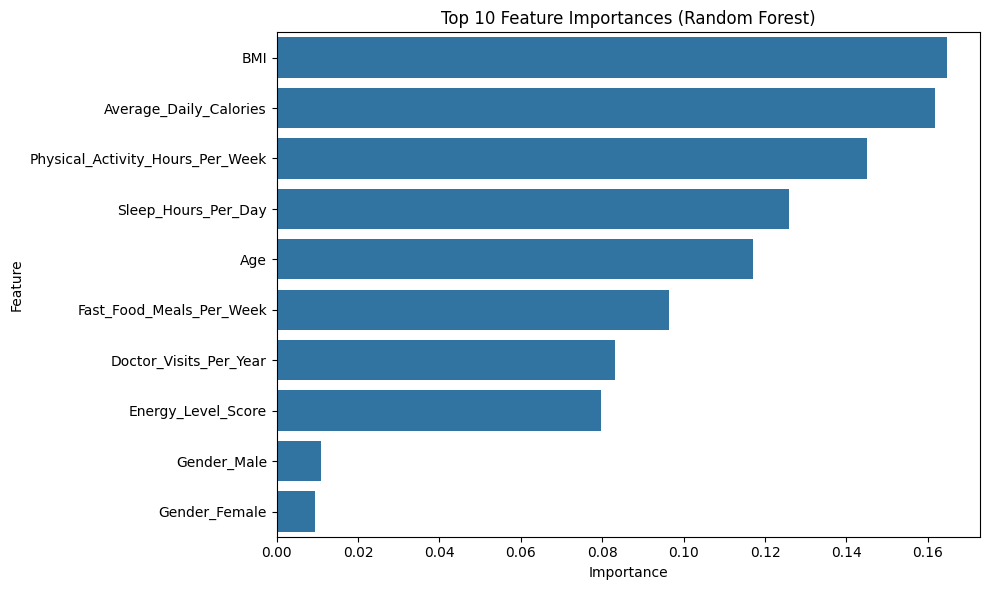


Top 10 Important Features:
                            Feature  Importance
3                               BMI    0.164597
2            Average_Daily_Calories    0.161674
4  Physical_Activity_Hours_Per_Week    0.144970
5               Sleep_Hours_Per_Day    0.125926
0                               Age    0.116939
1          Fast_Food_Meals_Per_Week    0.096329
7            Doctor_Visits_Per_Year    0.083251
6                Energy_Level_Score    0.079606
9                       Gender_Male    0.010948
8                     Gender_Female    0.009460


In [22]:
# Feature importance for Random Forest
rf_model = results['Random Forest']['model']
feature_names = numeric_features + list(
    rf_model.named_steps['preprocessor']
    .named_transformers_['cat']
    .get_feature_names_out(categorical_features)
)

importances = rf_model.named_steps['model'].feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title('Top 10 Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()

print("\nTop 10 Important Features:")
print(feature_importance_df.head(10))

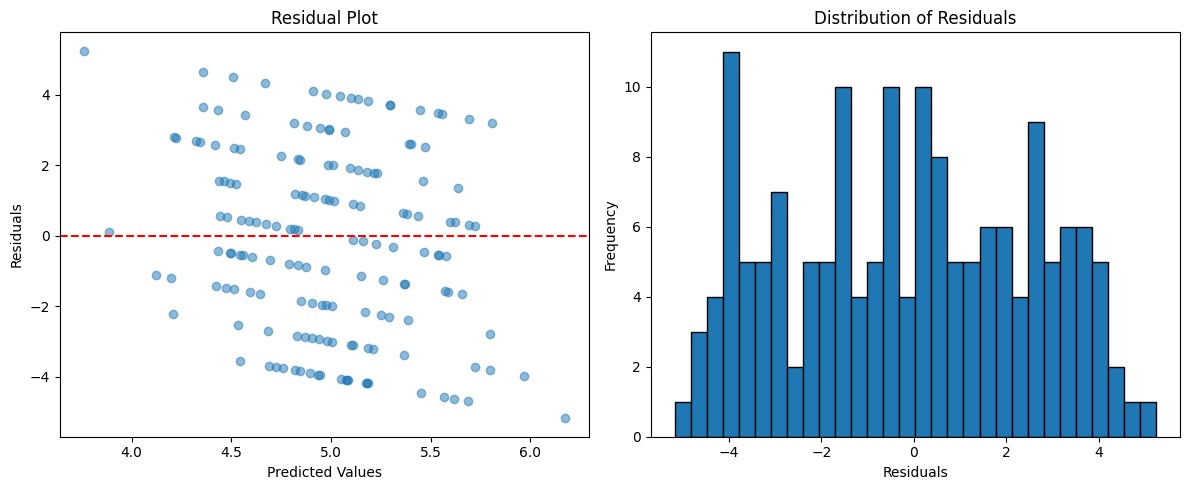


KEY INSIGHTS:
1. Target Distribution: Health scores are fairly evenly distributed
2. Top Correlated Features:
   - Energy Level Score: 0.056
   - Physical Activity: -0.059
   - Fast Food Meals: 0.037
3. Fast food consumption shows negative correlation with health score
4. Random Forest performed best among tested models
5. Energy level and physical activity are most important predictors


In [23]:
# Residual analysis for best model
best_model_name = comparison_df.iloc[0]['Model']
best_model = results[best_model_name]['model']

best_predictions = results[best_model_name]['predictions']
residuals = y_test - best_predictions

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(best_predictions, residuals, alpha=0.5)
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].set_xlabel('Predicted Values')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residual Plot')

axes[1].hist(residuals, bins=30, edgecolor='black')
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Residuals')

plt.tight_layout()
plt.show()

# %%
print("\n" + "="*50)
print("KEY INSIGHTS:")
print("="*50)
print("1. Target Distribution: Health scores are fairly evenly distributed")
print("2. Top Correlated Features:")
print(f"   - Energy Level Score: {target_corr['Energy_Level_Score']:.3f}")
print(f"   - Physical Activity: {target_corr['Physical_Activity_Hours_Per_Week']:.3f}")
print(f"   - Fast Food Meals: {target_corr['Fast_Food_Meals_Per_Week']:.3f}")
print("3. Fast food consumption shows negative correlation with health score")
print("4. Random Forest performed best among tested models")
print("5. Energy level and physical activity are most important predictors")